# Experimenting with various Kernel Combinations

Here I will be experimenting with a range of different kernel combinations, to see which one is able to model sunspot number the best.

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

## Preprocessing Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt

In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X)) 

In [3]:
df.head()

,Unnamed: 0,Year,Sunspot_Number
0,0,1818.001,34.566570
1,1,1818.004,34.546053
2,2,1818.007,34.525535
3,3,1818.010,34.505017
4,4,1818.012,34.484499


In [4]:
rng = np.random.RandomState(1) # random selection of points
training_indices = rng.choice(np.arange(y.size), size=200, replace=False)

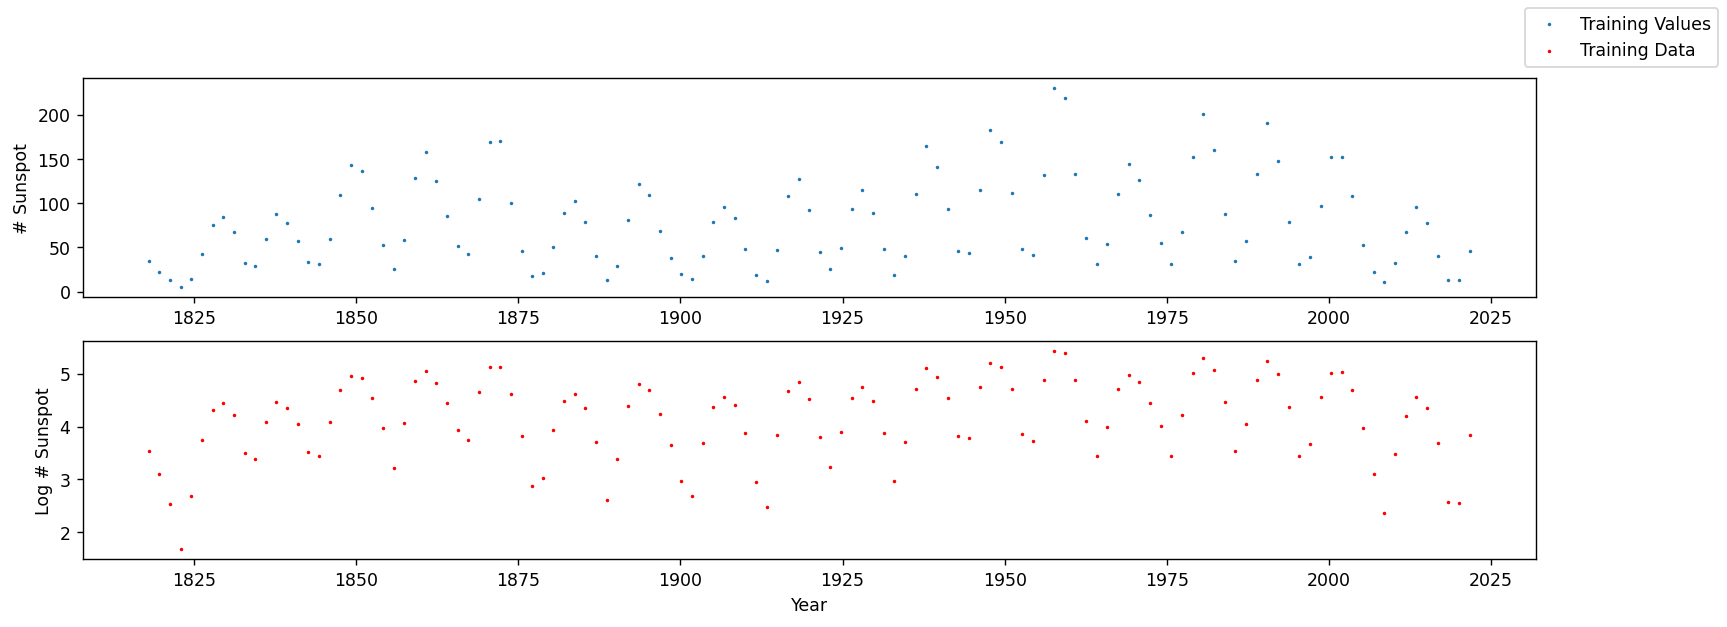

In [5]:
training_values = X[::600], y[::600]

training_data = training_values[0], np.log(training_values[1])  
# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

## Quasi-Periodic Kernel

#### (Squared Exponential * Periodic)

In [ ]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset

In [ ]:
# Define the Gaussian Process
with pm.Model() as model:
    
    # Define the phase of the sinusoidal mean
    phase = pm.Beta('phase', 2, 2)
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Gamma('amplitude', 2, 2)
    
    # Define the offset of the sinusoidal mean
    offset = pm.Gamma('offset', 2, 2)
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = 11
    
    # Define the `length scale 1' of the periodic kernel as a normal distribution with mean = 1 year
    length_scale1 = pm.Normal('Length Scale 1', 1, 1)  
    
    # Define the `length_scale 2' of the squared-exponential kernel as a normal distribution with mean = 9 years
    length_scale2 = pm.Normal('Length Scale 2', 9, 4)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Beta('$\sigma$', 2, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = cov_SE * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

In [ ]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12, grid=(1,6));
#plt.savefig('gp post.png'); 

In [ ]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])#

In [ ]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

## Rational Quadratic * Periodic

In [ ]:
# Define the Gaussian Process
with pm.Model() as model:
    
    # Define the phase of the sinusoidal mean
    #phase = pm.Beta('phase', 2, 2)
    
    # Define the amplitude
    A = pm.Gamma('amplitude', 7.5, 1)
    
    # Define the offset of the sinusoidal mean
    #offset = pm.Gamma('offset', 2, 2)
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = pm.Normal('Period', 11, 1)
    
    # Define the `length scale' of the periodic kernel
    length_scale = pm.Gamma('Length Scale 1', 7.5, 1)  
    
    # Define the 'length scale' of the RatQuad kernel
    length_scale2 = pm.Gamma('Length Scale 2', 7.5, 1)
    
    # Define 'alpha' of the rational-quadratic kernel
    alpha = pm.Gamma('alpha', 2, 2)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Gamma('$\sigma$', 2, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale)
    
    # Define the squared-exponential kernel
    cov_RatQuad = pm.gp.cov.RatQuad(1, alpha=alpha, ls=length_scale2)
    
    # Define the kernel
    cov = A**2 * cov_RatQuad * cov_periodic
    
    #sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov)#sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

In [ ]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12, grid=(1,6));
#plt.savefig('gp post.png'); 

In [ ]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])#

In [ ]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

# Predicting validation dataset

## Data Preprocessing

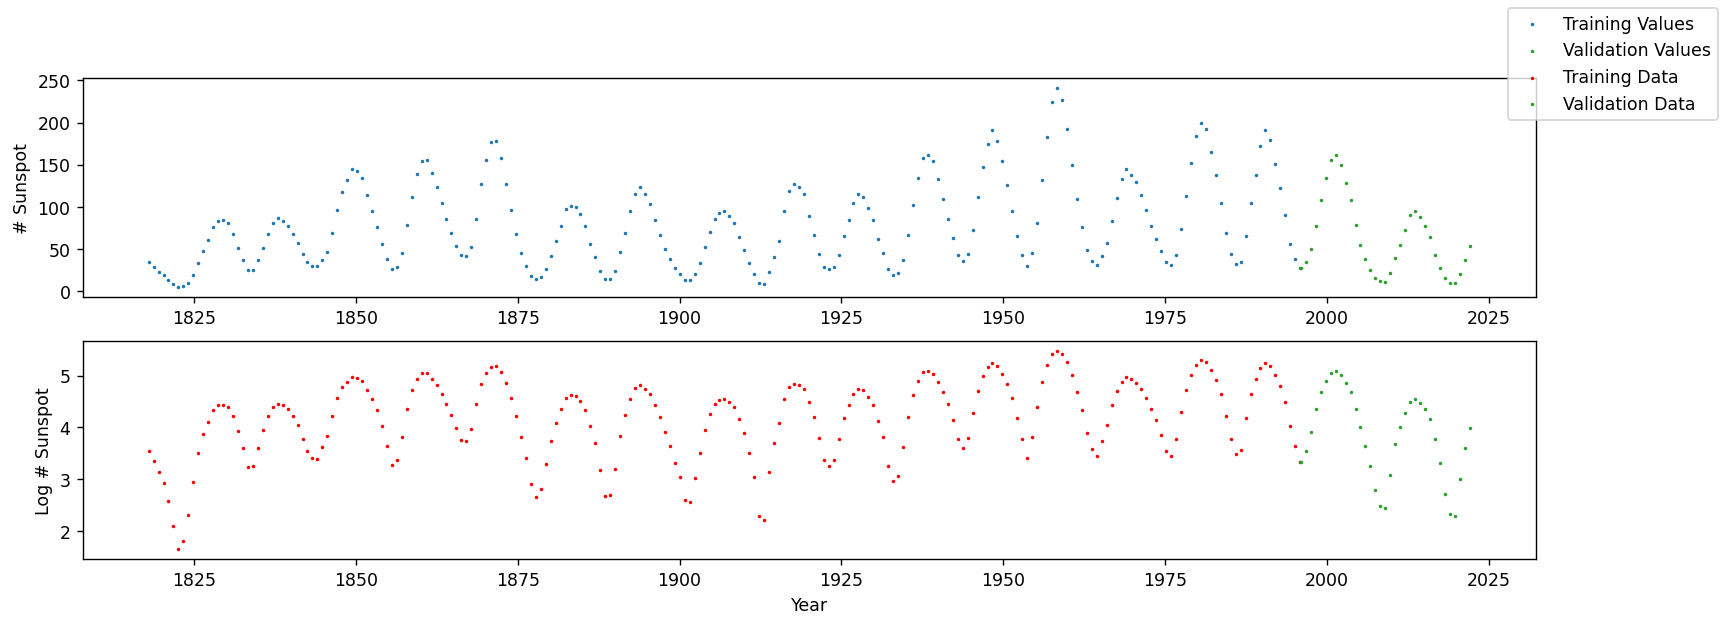

In [6]:
limit = 65000 # training with the first 70k datapoints
skips = 280 # 1 data point per 10 luna cycle
all_data = df.iloc[:70000]
train_data = df.iloc[:limit:skips] 
validation_data = df.iloc[limit::skips]

training_values = (train_data.Year.values).reshape(-1,1), train_data.Sunspot_Number.values
validation_values = (validation_data.Year.values).reshape(-1,1), validation_data.Sunspot_Number.values

training_data = training_values[0], np.log(training_values[1]) 
validation_data = validation_values[0], np.log(validation_values[1])

# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].scatter(validation_values[0], validation_values[1], label='Validation Values', s=1, color='tab:green')
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].scatter(validation_data[0], validation_data[1], label='Validation Data', s=1, color='tab:green')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

## GP Regression - Rational Quadratic * Periodic

In [7]:
# Define the Gaussian Process
with pm.Model() as model:
    
    # Define the phase of the sinusoidal mean
    #phase = pm.Beta('phase', 2, 2)
    
    # Define the amplitude
    A = pm.Gamma('amplitude', 7.5, 1)
    
    # Define the offset of the sinusoidal mean
    #offset = pm.Gamma('offset', 2, 2)
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = pm.Normal('Period', 11, 1)
    
    # Define the `length scale' of the periodic kernel
    length_scale = pm.Gamma('Length Scale 1', 7.5, 1)  
    
    # Define the 'length scale' of the RatQuad kernel
    length_scale2 = pm.Gamma('Length Scale 2', 7.5, 1)
    
    # Define 'alpha' of the rational-quadratic kernel
    alpha = pm.Gamma('alpha', 2, 2)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Gamma('$\sigma$', 2, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale)
    
    # Define the squared-exponential kernel
    cov_RatQuad = pm.gp.cov.RatQuad(1, alpha=alpha, ls=length_scale2)
    
    # Define the kernel
    cov = A**2 * cov_RatQuad * cov_periodic
    
    #sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov)#sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, alpha, Length Scale 2, Length Scale 1, Period, amplitude]


/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1554 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


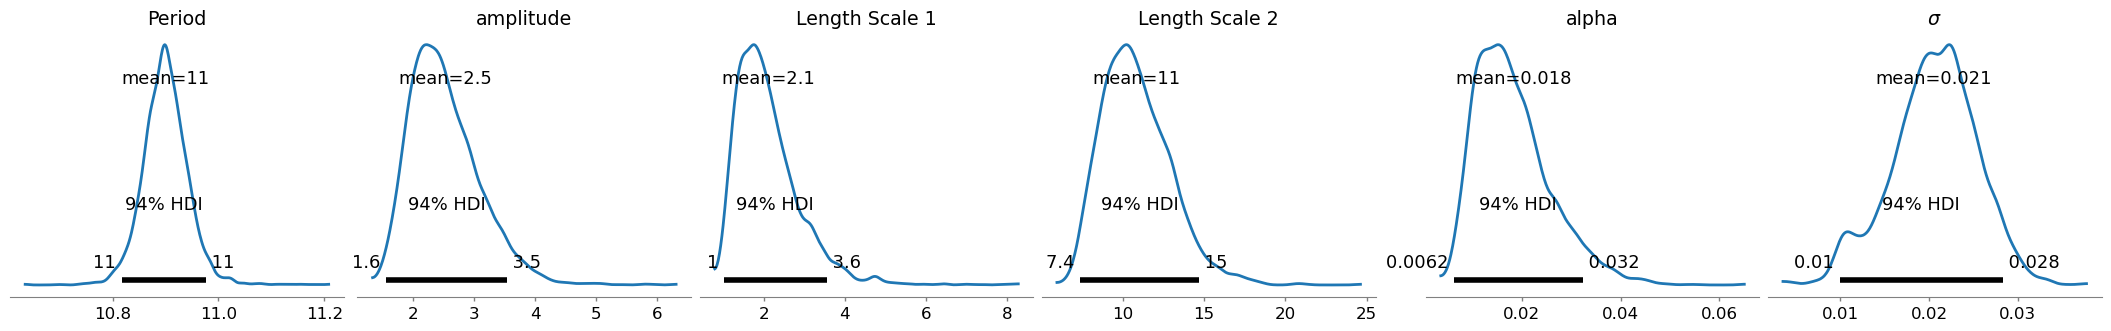

In [8]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12, grid=(1,6));
#plt.savefig('gp post.png'); 

In [9]:
X_new = np.linspace(1818, 2025, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])#

/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


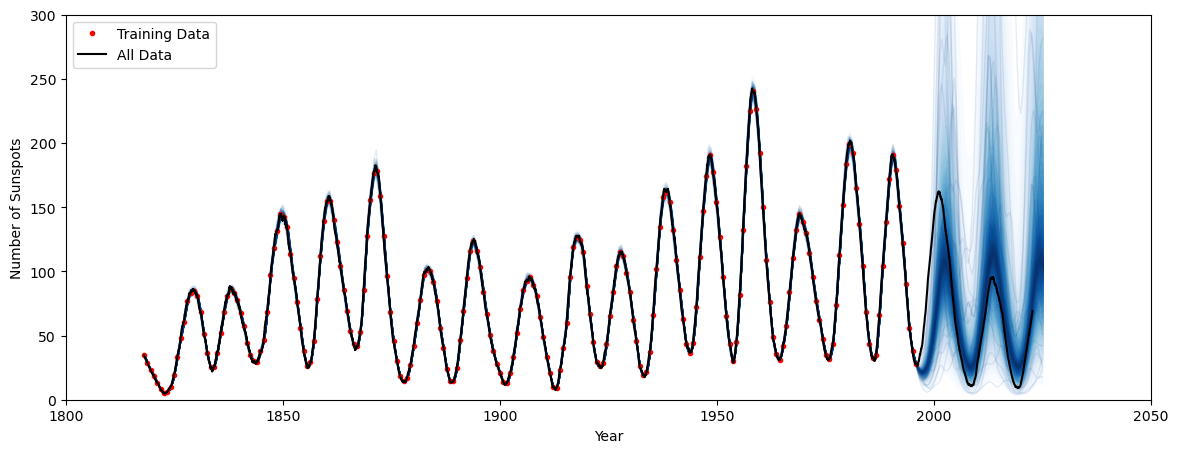

In [10]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")
#plt.plot(2009.635*np.ones(5), np.linspace(0,400,5), 'g--', label='End of training')
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

### Comment on plot:

Here we have performed the same GP as before, but now we have given the model 70,000 training values, and we ask it to predict the final few thousand points.

As we can see from the blue GP after we have finished training, the GP is unable to correctly predict what the values would be for sunspot number, the mode is smaller than the actual sunspot number recoreded. This seems to come from the problem with the mean function, as the mean's amplitude is still far too small.

**Edit**: For the latest run, I have used the parameters from the initial GP which takes all the data into account (**this is cheating**), just to see how well the GP performs. The figure above shows predictions which are generally closer to the actual values, however as we can see from the sampling there is still a huge uncertainty as to what the amplitude of the cycles are.